# Token Approximation — EDA and Baselines

Concise analysis and baseline models to approximate input token counts from local text features.

Technical depth (ablations, diagnostics, learning curves) is in `02_appendix_diagnostics.ipynb`.

## Overview and Hypothesis

- Hypothesis: Local text features (bytes, runes, words, lines) can approximate provider language model input token counts.
- Why it matters: Enables local budgeting without remote tokenizers, helpful for throughput, cost, and context management.
- Approach: Benchmark a simple single-feature baseline versus multifeature linear models with regularization; report held-out test performance plus train-CV stability.
- Scope: Token counts are tokenizer- and language model-specific; external validity may vary.
- Terminology: “runes” = Unicode code points; features used: bytes, runes, words, lines.

## Data

- Data source: `output/records.jsonl` produced by the Go features runner over sample texts.
- Columns: `bytes`, `runes` (Unicode code points), `words`, `lines`, `input_tokens`, `model`, `source_path`.

### Imports

In [1]:
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from IPython.display import display, Markdown
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from utils import (
    SEED as SEED_DEFAULT, N_GRID_DEFAULT, MAPE_THRESHOLD_DEFAULT, DECISION_MARGIN_DEFAULT,
    CV_SPLITS_A_DEFAULT, CV_SPLITS_DEFAULT, CV_REPEATS_DEFAULT, BOOT_B_DEFAULT, FEATURES,
    load_records, validate_records, corr_heatmap,
    cv_single_feature, select_best, fit_single_feature,
    approach_b_ols, approach_b_ridge_cv, approach_b_elasticnet_cv,
    summarize_and_decide, repeated_cv_mae, bootstrap_mae_ci,
    export_single_feature, export_linear_multifeature, coef_sanity_checks,
    save_fig,
)

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

### Configuration

In [2]:
# Defaults can be overridden as needed
SEED = SEED_DEFAULT  # random seed for splits/CV
N_GRID = N_GRID_DEFAULT  # learning-curve grid
MAPE_THRESHOLD = MAPE_THRESHOLD_DEFAULT  # floor for computing MAPE
DECISION_MARGIN = DECISION_MARGIN_DEFAULT  # min relative MAE gain to pick B over A
CV_SPLITS_A = CV_SPLITS_A_DEFAULT  # folds for A-selection CV
CV_SPLITS = CV_SPLITS_DEFAULT  # folds for stability CV + learning curves
CV_REPEATS = CV_REPEATS_DEFAULT  # repeats for stability CV
BOOT_B = BOOT_B_DEFAULT  # bootstrap resamples
MODEL_NAME = "claude-3-7-sonnet-latest"  # tokenizer/model scope

display(Markdown(
    f"""Constants set for this run:
- `SEED`=`{SEED}`
- `DECISION_MARGIN`=`{DECISION_MARGIN}`
- `MAPE_THRESHOLD`=`{MAPE_THRESHOLD}`
- `CV_SPLITS` x `CV_REPEATS`=`{CV_SPLITS}` x `{CV_REPEATS}`
"""
))

Constants set for this run:
- `SEED`=`42`
- `DECISION_MARGIN`=`0.03`
- `MAPE_THRESHOLD`=`50`
- `CV_SPLITS` x `CV_REPEATS`=`10` x `5`


### Load and Validate Data

In [3]:
base = Path('..').resolve()
records_path = base / 'output' / 'records.jsonl'
print({'records_path': str(records_path)})

df = load_records(records_path)
df = validate_records(df)
print(df.attrs.get('validation_info', {}))
df.head()

{'records_path': '/Users/peta/Documents/dev/token-approx/output/records.jsonl'}
{'total_before': 25, 'drops': {'input_tokens_na': 0, 'bytes_non_numeric_or_na': 0, 'runes_non_numeric_or_na': 0, 'words_non_numeric_or_na': 0, 'lines_non_numeric_or_na': 0}, 'total_after': 25}


,bytes,runes,words,lines,input_tokens,model,source_path
0,36027,35491,6086,702,9566,claude-3-7-sonnet-latest,poc_token_approx/input/samples/oliver-twist_gb...
1,36733,35737,6209,747,9702,claude-3-7-sonnet-latest,poc_token_approx/input/samples/oliver-twist_gb...
2,36961,35965,6199,735,9798,claude-3-7-sonnet-latest,poc_token_approx/input/samples/oliver-twist_gb...
3,36649,35953,6438,719,9552,claude-3-7-sonnet-latest,poc_token_approx/input/samples/oliver-twist_gb...
4,36572,35584,6297,776,9536,claude-3-7-sonnet-latest,poc_token_approx/input/samples/oliver-twist_gb...


## Exploratory Visuals

{'saved': '/Users/peta/Documents/dev/token-approx/output/figures/fig_main_scatter_grid.png'}


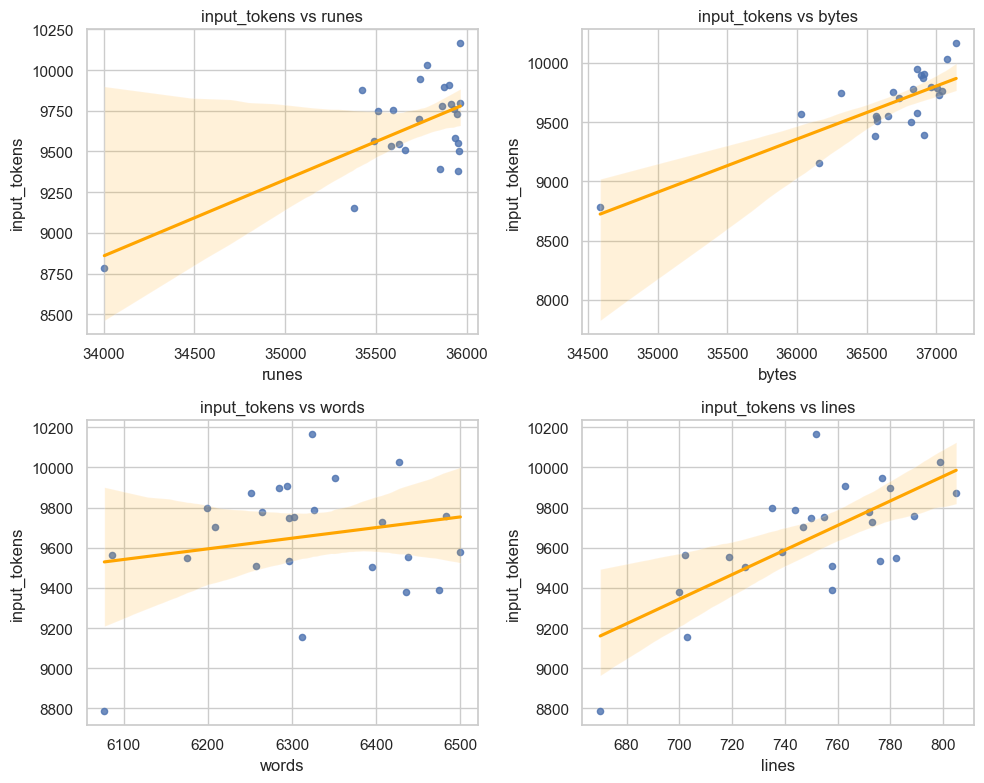

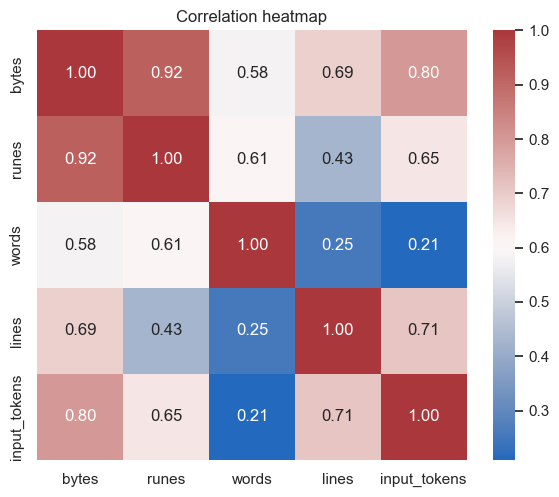

{'saved': '/Users/peta/Documents/dev/token-approx/output/figures/fig_b_corr_heatmap.png'}


In [4]:
sns.set_theme(style='whitegrid')

# 2x2 scatter grid with trend lines
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pairs = [('runes','input_tokens'), ('bytes','input_tokens'), ('words','input_tokens'), ('lines','input_tokens')]
for ax, (x,y) in zip(axes.ravel(), pairs):
    sns.regplot(data=df, x=x, y=y, scatter_kws={'s':20, 'alpha':0.8}, line_kws={'color':'orange'}, ax=ax)
    ax.set_title(f'{y} vs {x}')
plt.tight_layout()
scatter_path = save_fig(fig, 'fig_main_scatter_grid')
print({'saved': str(scatter_path)})

# Correlation heatmap
ax = corr_heatmap(df)
heatmap_path = save_fig(ax, 'fig_b_corr_heatmap')
print({'saved': str(heatmap_path)})

### Takeaways

- Strong linear trends between input tokens and bytes/runes.
- Features are correlated; multicollinearity likely → regularization/subset selection is appropriate.

## Approach A — Single-Feature Linear Regression: CV Selection

Train: CV to select feature/intercept. Evaluate on a held‑out test split.

MAE is the headline metric. MAPE is reported only when `y`>=`MAPE_THRESHOLD` to avoid instability on small targets.

Single-feature baseline calibrates expectations before multi-feature models

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# CV across single features and intercept options
features_list = FEATURES
rows = []
for feat in features_list:
    Xtr_feat = train_df[[feat]].to_numpy()
    ytr = train_df['input_tokens'].to_numpy()
    for fi in (False, True):
        mae_cv, bias_cv = cv_single_feature(Xtr_feat, ytr, fit_intercept=fi, n_splits=CV_SPLITS_A, seed=SEED)
        rows.append({'feature': feat, 'fit_intercept': fi, 'cv_mae': mae_cv, 'cv_bias': bias_cv})
cv_results = pd.DataFrame(rows).sort_values(['cv_mae', 'feature', 'fit_intercept']).reset_index(drop=True)

best_cv = select_best(cv_results)
res_a = fit_single_feature(train_df, test_df, feature=best_cv['feature'], fit_intercept=bool(best_cv['fit_intercept']))

# Export CV table
out_tables = (Path('..')/ 'output' / 'tables'); out_tables.mkdir(parents=True, exist_ok=True)
cv_csv = out_tables / 'cv_single_feature_results.csv'
cv_results.to_csv(cv_csv, index=False)

display(Markdown('#### CV results (train) (Approach A)'))
display(cv_results)

y_true_sf = res_a['yte']; y_pred_sf = res_a['pred']
mask = y_true_sf >= MAPE_THRESHOLD
mape = None if not mask.any() else float(np.mean(np.abs((y_true_sf[mask] - y_pred_sf[mask]) / y_true_sf[mask])))

display(Markdown('#### Held-out Test Results (Approach A)'))
display(pd.DataFrame([{
    'stage': 'A_single_feature_test',
    'feature': res_a['feature'],
    'fit_intercept': res_a['fit_intercept'],
    'test_mae': res_a['test_mae'],
    'test_bias': res_a['test_bias'],
    'MAPE_after_filter': mape,
    'MAPE_after_filter_pct': None if mape is None else 100*mape,
}]))

#### CV results (train) (Approach A)

,feature,fit_intercept,cv_mae,cv_bias
0,bytes,True,144.427594,7.752838
1,bytes,False,169.869769,-1.329659
2,runes,False,201.408403,-0.881323
3,lines,True,207.923194,-19.519454
4,runes,True,245.207236,-56.612640
5,lines,False,273.942573,7.287553
6,words,False,274.350196,1.557482
7,words,True,283.337983,-18.730074


#### Held-out Test Results (Approach A)

,stage,feature,fit_intercept,test_mae,test_bias,MAPE_after_filter,MAPE_after_filter_pct
0,A_single_feature_test,bytes,True,154.600783,75.950348,0.01585,1.584973


## Approach B — Multi-Feature Linear Regression: OLS-best-subset; Ridge/ElasticNet via CV

Train: OLS subset search; Ridge/ElasticNet via CV. Evaluate on a held‑out test split.

In [6]:
# 1) Regularized baselines (Ridge, ElasticNet)
res_b_ridge = approach_b_ridge_cv(train_df, test_df, seed=SEED)
res_b_enet = approach_b_elasticnet_cv(train_df, test_df, seed=SEED)

# 2) OLS best-subset on train/test (exhaustive over all non-empty feature subsets)
def fit_ols_subset_return_full(train_df, test_df, cols):
    Xtr = train_df[list(cols)].to_numpy()
    ytr = train_df['input_tokens'].to_numpy()
    Xte = test_df[list(cols)].to_numpy()
    yte = test_df['input_tokens'].to_numpy()

    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xtr, ytr)
    pte = lr.predict(Xte)
    mae = float(mean_absolute_error(yte, pte))
    bias = float(np.mean(yte - pte))
    r2 = float(r2_score(yte, pte))
    coefs = dict(zip(list(cols), map(float, lr.coef_)))

    return {
        'model': 'OLS_best_subset',
        'test_mae': mae,
        'test_bias': bias,
        'test_r2': r2,
        'intercept': float(lr.intercept_),
        'coefs': coefs,
        'yte': yte,
        'pred': pte,
        'cols': list(cols),
    }

# Search using one quick pass with fit_eval-like logic to get MAE, then refit once for the winner
best_subset = None
best_mae = np.inf

for r in range(1, len(FEATURES) + 1):
    for cols in combinations(sorted(FEATURES), r):
        tmp = fit_ols_subset_return_full(train_df, test_df, cols)
        if tmp['test_mae'] < best_mae:
            best_mae = tmp['test_mae']
            best_subset = tmp

res_b_ols = best_subset

# Show results
def _features_from_result(res):
    if 'coefs' in res and isinstance(res['coefs'], dict) and res['coefs']:
        return ','.join(sorted(res['coefs'].keys()))
    cols = res.get('cols', [])
    return ','.join(cols) if cols else 'bytes,runes,words,lines'

def _row(res, family, selection_basis):
    row = {
        'family': family,
        'model': res.get('model', family),
        'selection': selection_basis,
        'features': _features_from_result(res),
        'test_mae': float(res['test_mae']),
        'test_bias': float(res['test_bias']),
    }
    if 'alpha' in res: row['alpha'] = res['alpha']
    if 'l1_ratio' in res: row['l1_ratio'] = res['l1_ratio']
    return row

# Build finalists (one per family)
b_rows = []
if res_b_ols is not None:
    b_rows.append(_row(res_b_ols, family='OLS', selection_basis='best subset by test MAE'))
if res_b_ridge is not None:
    b_rows.append(_row(res_b_ridge, family='Ridge', selection_basis='alpha via CV on train'))
if res_b_enet is not None:
    b_rows.append(_row(res_b_enet, family='ElasticNet', selection_basis='alpha,l1_ratio via CV on train'))

b_df = pd.DataFrame(b_rows).sort_values('test_mae').reset_index(drop=True)

# Add improvement vs A and highlight best
a_mae = float(res_a['test_mae'])
b_df_enh = b_df.copy()
b_df_enh['improve_vs_A_pct'] = 100.0 * (a_mae - b_df_enh['test_mae']) / a_mae

def _hl_best(s):
    is_best = (s.index == b_df_enh['test_mae'].idxmin())
    return ['font-weight: bold; background-color: #1e3a8a22' if v else '' for v in is_best]

display(Markdown("### Held‑out Test Results (Approach B finalists)"))
display(Markdown("_Each row is the best candidate for its family (OLS best subset; Ridge and ElasticNet with CV-selected hyperparameters)._"))
display(
    b_df_enh[['family','model','selection','features','test_mae','test_bias','improve_vs_A_pct','alpha','l1_ratio']]
    .style.format({'test_mae':'{:.2f}','test_bias':'{:.2f}','improve_vs_A_pct':'{:+.1f}%'})
    .apply(_hl_best, axis=0)
)

/Users/peta/Documents/dev/token-approx/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


### Held‑out Test Results (Approach B finalists)

_Each row is the best candidate for its family (OLS best subset; Ridge and ElasticNet with CV-selected hyperparameters)._

,family,model,selection,features,test_mae,test_bias,improve_vs_A_pct,alpha,l1_ratio
0,OLS,OLS_best_subset,best subset by test MAE,"bytes,words",128.64,45.73,+16.8%,nan,nan
1,ElasticNet,ElasticNetCV,"alpha,l1_ratio via CV on train","bytes,lines,runes,words",134.75,36.06,+12.8%,0.484369,0.500000
2,Ridge,Ridge,alpha via CV on train,"bytes,lines,runes,words",141.15,28.13,+8.7%,1.000000,nan


## Model Selection and Decision

We select B only if it reduces MAE over A by more than the `DECISION_MARGIN`, to avoid overreacting to small differences.

In [7]:
summary_b = summarize_and_decide(
    res_a,
    res_b_ols=res_b_ols,
    res_b_ridge=res_b_ridge,
    res_b_enet=res_b_enet,
    prefer_margin=DECISION_MARGIN,
)

# Render a readable decision summary and compact metrics table
rows = [
    {
        'approach': 'A_single_feature',
        'feature': res_a['feature'],
        'fit_intercept': res_a['fit_intercept'],
        'test_mae': res_a['test_mae'],
        'test_bias': res_a['test_bias'],
    }
]
bd = summary_b.get('B_details')
if isinstance(bd, dict):
    # Derive a readable feature list from the candidate's coefs
    feat_str = ','.join(sorted(bd.get('coefs', {}).keys()))
    rows.append({
        'approach': f"B_{bd.get('model')}",
        'feature': feat_str if feat_str else 'bytes,runes,words,lines',
        'fit_intercept': True,
        'test_mae': bd.get('test_mae'),
        'test_bias': bd.get('test_bias'),
    })

display(Markdown(f"### Held‑out Test Results - A vs B Decision"))
display(Markdown(f"#### Decision: {summary_b.get('decision')} -—> {summary_b.get('reason')}"))
display(pd.DataFrame(rows))

### Held‑out Test Results - A vs B Decision

#### Decision: B -—> Approach B (OLS_best_subset) beats A by 16.8% MAE (> 3% margin).

,approach,feature,fit_intercept,test_mae,test_bias
0,A_single_feature,bytes,True,154.600783,75.950348
1,B_OLS_best_subset,"bytes,words",True,128.641883,45.734170


### Takeaways

- On this split, B (OLS best-subset bytes+words) outperforms A by ~17% MAE and lowers bias.
- This means tighter token budgeting with similar calibration (split-dependent).

## Stability and Uncertainty

Repeated-CV (stability) with bootstrap CIs (uncertainty) on train to assess for A and the chosen B.

In [8]:
# Reporting: repeated-CV (train-only) + bootstrap CI for A and chosen B

# Train-only repeated-CV
y_all = train_df['input_tokens'].to_numpy()
mean_y = float(train_df['input_tokens'].mean())

# A
feat = best_cv['feature']
fi = bool(best_cv['fit_intercept'])
XA = train_df[[feat]].to_numpy()
maeA, ytA, ypA = repeated_cv_mae(
    XA, y_all,
    model_factory=lambda: LinearRegression(fit_intercept=fi),
    n_splits=CV_SPLITS, n_repeats=CV_REPEATS, seed=SEED,
)
loA, hiA = bootstrap_mae_ci(ytA, ypA, B=BOOT_B, seed=SEED)
biasA = float(np.mean(ytA - ypA))

# B (use chosen best model params if available)
B_row = None
if summary_b['B_best_model'] is not None:
    model_name = summary_b['B_best_model']
    
    # Determine the feature set to use for repeated-CV
    if model_name in ('OLS', 'OLS_best_subset'):
        # Use the exact subset chosen (derived from coef keys)
        feature_set = sorted(summary_b['B_details'].get('coefs', {}).keys())
        XB = train_df[feature_set].to_numpy()
        mf = lambda: LinearRegression(fit_intercept=True)
    elif model_name == 'Ridge':
        feature_set = ['bytes','runes','words','lines']
        alpha = summary_b['B_details'].get('alpha', 1.0)
        XB = train_df[feature_set].to_numpy()
        mf = lambda: Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha, fit_intercept=True)),
        ])
    elif model_name == 'ElasticNetCV':
        feature_set = ['bytes','runes','words','lines']
        alpha = summary_b['B_details'].get('alpha', 1.0)
        l1_ratio = summary_b['B_details'].get('l1_ratio', 0.5)
        XB = train_df[feature_set].to_numpy()
        mf = lambda: Pipeline([
            ('scaler', StandardScaler()),
            ('enet', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=100000, random_state=SEED)),
        ])
    else:
        mf = None
        feature_set = None

    if mf is not None:
        maeB, ytB, ypB = repeated_cv_mae(
            XB, y_all,
            model_factory=mf,
            n_splits=CV_SPLITS, n_repeats=CV_REPEATS, seed=SEED,
        )
        loB, hiB = bootstrap_mae_ci(ytB, ypB, B=BOOT_B, seed=SEED)
        biasB = float(np.mean(ytB - ypB))
        B_row = {
            'approach': f"B_{model_name}",
            'feature': ','.join(feature_set) if feature_set else 'bytes,runes,words,lines',
            'fit_intercept': True,
            'MAE': float(maeB),
            'CI95_lo': float(loB),
            'CI95_hi': float(hiB),
            'bias': biasB,
        }

rows = [
    {
        'approach': f"A_single_feature({feat}{',+b' if fi else ''})",
        'feature': feat,
        'fit_intercept': fi,
        'MAE': float(maeA),
        'CI95_lo': float(loA),
        'CI95_hi': float(hiA),
        'bias': biasA,
    }
]
if B_row is not None:
    rows.append(B_row)

report_df = pd.DataFrame(rows, columns=['approach','feature','fit_intercept','MAE','CI95_lo','CI95_hi','bias'])
display(Markdown('#### Train-CV stability (MAE with 95% CI)'))
display(report_df)

#### Train-CV stability (MAE with 95% CI)

,approach,feature,fit_intercept,MAE,CI95_lo,CI95_hi,bias
0,"A_single_feature(bytes,+b)",bytes,True,163.065026,138.916261,189.105635,16.031685
1,B_OLS_best_subset,"bytes,words",True,143.376267,124.067713,163.411822,3.711023


## Error Analysis (Test)

Absolute error distribution for the chosen model; we report median and 95th percentile.

Typical error (chosen model B_OLS_best_subset): median 97.2 tokens; p95 265.7; max 280.3.

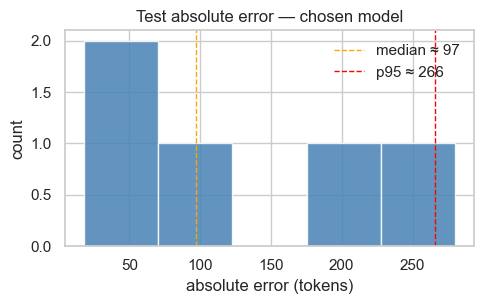

In [9]:
# Determine chosen model and collect test predictions
choice = summary_b.get('decision') if isinstance(summary_b, dict) else None
if choice == 'A':
    y_true = res_a['yte']
    y_pred = res_a['pred']
    chosen_label = f"A_single_feature({res_a['feature']}{',+b' if res_a['fit_intercept'] else ''})"
elif choice == 'B':
    model_name = summary_b.get('B_best_model')
    if model_name in ('OLS', 'OLS_best_subset'):
        res = res_b_ols
    elif model_name == 'Ridge':
        res = res_b_ridge
    else:
        res = res_b_enet
    y_true = res['yte']
    y_pred = res['pred']
    chosen_label = f"B_{model_name}"
else:
    y_true = res_a['yte']
    y_pred = res_a['pred']
    chosen_label = 'A_single_feature (fallback)'

# Absolute error stats
abs_err = np.abs(y_true - y_pred)
med = float(np.median(abs_err))
p95 = float(np.percentile(abs_err, 95))
mx  = float(np.max(abs_err))
n   = len(abs_err)

# Histogram with median/p95 refs
fig, ax = plt.subplots(figsize=(5, 3.2))
bins = max(3, min(7, n))  # small, readable bin count for tiny n
ax.hist(abs_err, bins=bins, color='steelblue', alpha=0.85, edgecolor='white')
ax.axvline(med, color='orange', ls='--', lw=1, label=f'median ≈ {med:.0f}')
ax.axvline(p95, color='red', ls='--', lw=1, label=f'p95 ≈ {p95:.0f}')
ax.set_title('Test absolute error — chosen model')
ax.set_xlabel('absolute error (tokens)')
ax.set_ylabel('count')
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()

_ = save_fig(fig, 'fig_main_test_abs_err')  # saved to output/figures

display(Markdown(
    f"Typical error (chosen model {chosen_label}): "
    f"median {med:.1f} tokens; p95 {p95:.1f}; max {mx:.1f}."
))

### Takeaways

- n=5 test set → indicative only.
- Typical error ≈ 100 tokens; tail ≈ 250–280 tokens.
- Good enough for budgeting; add a safety buffer when near limits.

## Exports and Artifacts

Export the final test metrics table and the chosen model coefficients for reuse.

In [10]:
out_tables = (Path('..')/ 'output' / 'tables'); out_tables.mkdir(parents=True, exist_ok=True)

rows = [
    {
        'approach': 'A_single_feature',
        'feature': res_a['feature'],
        'fit_intercept': res_a['fit_intercept'],
        'test_mae': res_a['test_mae'],
        'test_bias': res_a['test_bias'],
    }
]
if isinstance(summary_b.get('B_details'), dict):
    bd = summary_b['B_details']
    feat_str = ','.join(sorted(bd.get('coefs', {}).keys()))
    rows.append({
        'approach': f"B_{bd.get('model')}",
        'feature': feat_str if feat_str else 'bytes,runes,words,lines',
        'fit_intercept': True,
        'test_mae': bd.get('test_mae'),
        'test_bias': bd.get('test_bias'),
    })

# Save CSV
final_csv = out_tables / 'final_test_metrics.csv'
pd.DataFrame(rows, columns=['approach','feature','fit_intercept','test_mae','test_bias']).to_csv(final_csv, index=False)
print({'saved': str(final_csv)})

# Export selected model based on decision summary
MODEL_NAME = MODEL_NAME
try:
    decision = summary_b.get('decision') if isinstance(summary_b, dict) else None
    if decision == 'A' and isinstance(res_a, dict):
        out_path = export_single_feature(
            feature_type=res_a['feature'],
            a=res_a['coef_a'],
            b=res_a['intercept_b'],
            model=MODEL_NAME,
            scope='en-long-one-turn',
            estimator='LinearRegression',
            fit_intercept=res_a['fit_intercept'],
        )
        print({'exported': str(out_path), 'type': 'single', 'feature': res_a['feature']})
    elif decision == 'B' and isinstance(summary_b.get('B_details'), dict):
        best_b = summary_b['B_details']
        flags = coef_sanity_checks(best_b.get('coefs', {}))
        if flags.get('negative_bytes') or flags.get('negative_runes'):
            print({'warning': 'coef sanity flags', **flags})

        # Feature set: derive from coefs keys (works for subset or full)
        feature_set = sorted(best_b.get('coefs', {}).keys())

        out_path = export_linear_multifeature(
            intercept=best_b['intercept'],
            coefs=best_b['coefs'],
            model=MODEL_NAME,
            scope='en-long-one-turn',
            estimator=best_b.get('model'),  # e.g., 'OLS_best_subset', 'Ridge', 'ElasticNetCV'
            feature_set=feature_set,
        )
        print({'exported': str(out_path), 'type': 'linear', 'model': best_b.get('model'), 'alpha': best_b.get('alpha', None), 'feature_set': feature_set})
    else:
        print({'export': 'skipped', 'reason': 'missing or invalid decision summary'})
except NameError as e:
    print({'export': 'skipped', 'reason': f'NameError: {e}'})

{'saved': '../output/tables/final_test_metrics.csv'}
{'exported': '/Users/peta/Documents/dev/token-approx/output/model_coefs.json', 'type': 'linear', 'model': 'OLS_best_subset', 'alpha': None, 'feature_set': ['bytes', 'words']}


## Further Exploration

For learning curves and extended diagnostics, see the companion appendix notebook: `02_appendix_diagnostics.ipynb`.

## Reproducibility

- Python: 3.10+
- Install: `pip install -r requirements.txt`
- Data path: `output/records.jsonl`
- Seeds and CV folds are controlled via the `Constants` section.

In [11]:
display(Markdown(f"""### Library versions:\n{'\n'.join([f'- {k}: {v}' for k, v in {'numpy': np.__version__, 'pandas': pd.__version__, 'sklearn': sklearn.__version__}.items()])}"""))

### Library versions:
- numpy: 2.3.4
- pandas: 2.3.3
- sklearn: 1.7.2